<a href="https://colab.research.google.com/github/fboldt/aulasml/blob/master/aula7b_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_iris
dataset = load_iris()
X, y = dataset.data, dataset.target

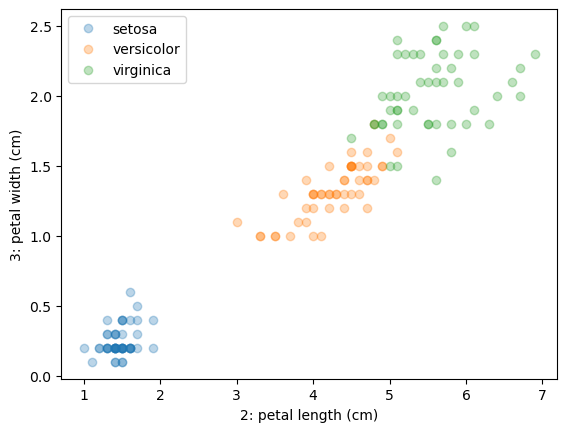

In [2]:
import matplotlib.pyplot as plt
i, j = 2,3
plt.xlabel(f"{i}: {dataset.feature_names[i]}")
plt.ylabel(f"{j}: {dataset.feature_names[j]}")
for k in set(y):
  plt.plot(X[:,i][y==k], X[:,j][y==k], "o", alpha=0.3,
           label=f"{dataset.target_names[k]}")
plt.legend()
plt.show()

In [3]:
import random
import numpy as np
def sorteiaCaracteristica(X, y):
  caracteristica = random.randint(a=0, b=X.shape[1]-1)
  valor = random.uniform(a=np.min(X[:,caracteristica]), b=np.max(X[:,caracteristica]))
  return caracteristica, valor
sorteiaCaracteristica(X, y)

(3, 1.2929376200846703)

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
from sklearn.model_selection import cross_validate

def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica, self.valor = sorteiaCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)

    # atributo necessário para ser usado pelo predict_proba
    self.classes_ = np.unique(y)
    return self
  def predict(self, X):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:, self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y
  
  # prob para cada classe da amsotra
  def predict_proba(self, X):
    y_proba = np.zeros((X.shape[0], len(np.unique(y))))
    if hasattr(self, 'resposta'): # chegou ao nó
        y_proba[:, self.resposta] = 1.0
    else:
        maiores = X[:, self.caracteristica] > self.valor
        y_proba[maiores] = self.maiores.predict_proba(X[maiores, :])
        y_proba[~maiores] = self.menores.predict_proba(X[~maiores, :])
    return y_proba

results = cross_validate(Arvore(), X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.96666667, 0.93333333, 0.93333333, 0.93333333, 0.9       ]),
 0.9333333333333333)

In [5]:
from sklearn.ensemble import BaggingClassifier
modelo = BaggingClassifier(Arvore(),
                           n_estimators=100)
results = cross_validate(modelo, X, y)
results['test_score'], np.mean(results['test_score'])

/home/lucas/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucas/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/lucas/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/lucas/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/lucas/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/lucas/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py", li

(array([nan, nan, nan, nan, nan]), nan)

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

modelo = BaggingClassifier(DecisionTreeClassifier(splitter='random'),
                           n_estimators=100)
results = cross_validate(modelo, X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.96666667, 0.96666667, 0.9       , 0.93333333, 1.        ]),
 0.9533333333333334)

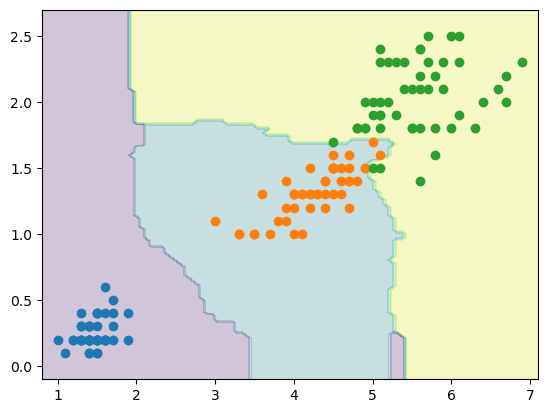

In [7]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{dataset.target_names[k]} [{k}]")
    plt.show()

plotDecisao(modelo, X[:,2:], y)

In [8]:
from sklearn.ensemble import RandomForestClassifier

results = cross_validate(RandomForestClassifier(), X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ]), 0.96)

In [9]:
from sklearn.ensemble import ExtraTreesClassifier

results = cross_validate(ExtraTreesClassifier(), X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.96666667, 0.96666667, 0.9       , 0.93333333, 1.        ]),
 0.9533333333333334)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

modelo = VotingClassifier([
    ('knn', KNeighborsClassifier()),
    ('svm', SVC()),
    ('tree', DecisionTreeClassifier())
])

results = cross_validate(modelo, X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.96666667, 0.96666667, 0.96666667, 0.96666667, 1.        ]),
 0.9733333333333334)